<a href="https://colab.research.google.com/github/jonyghosh444/transformer-res-ger/blob/master/DSDM_JAX_ENCODED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import os

In [ ]:
def fix_seed(seed=42):
    print("[ Using Seed:", seed, "]")
    random.seed(seed)
    np.random.seed(seed)
    jax.random.PRNGKey(seed)

In [ ]:
def load_encoded_dataset(npz_path, normalize=False):
    data = np.load(npz_path)
    train_x = jnp.array(data['traindata'])
    test_x = jnp.array(data['testdata'])

    if normalize:
        mean = jnp.mean(train_x, axis=0)
        std = jnp.std(train_x, axis=0) + 1e-8
        train_x = (train_x - mean) / std
        test_x = (test_x - mean) / std

    return train_x, jnp.array(data['trainlabel']), test_x, jnp.array(data['label_test'])

In [ ]:
def randomized_class_split(Y, n_tasks, classes_per_task, seed):
    all_classes = list(set(Y.tolist()))
    np.random.seed(seed)
    np.random.shuffle(all_classes)
    return [all_classes[i:i+classes_per_task] for i in range(0, n_tasks * classes_per_task, classes_per_task)]

In [ ]:
def split_dataset_by_class(X, Y, class_splits):
    split_x = []
    split_y = []
    for cls_group in class_splits:
        idxs = jnp.isin(Y, jnp.array(cls_group))
        split_x.append(X[idxs])
        split_y.append(Y[idxs])
    return split_x, split_y

In [ ]:
dataset = "core50"  # Options: "core50", "cifar10", "cifar100"
normalize = True

In [ ]:
if dataset == "core50":
    npz_path = "/content/drive/MyDrive/researchSupportProject/task/dataset/Core50_resnet18_224.npz"
    n_class = 50
    task_split = (9, 5)
elif dataset == "cifar10":
    npz_path = "/content/drive/MyDrive/transformer-r&d/dataset/data/CIFAR10_resnet18_224.npz"
    n_class = 10
    task_split = (5, 2)
elif dataset == "cifar100":
    npz_path = "/content/drive/MyDrive/transformer-r&d/dataset/data/CIFAR100_resnet18_224.npz"
    n_class = 100
    task_split = (20, 5)
else:
    raise ValueError("Dataset must be 'core50', 'cifar10', or 'cifar100'")

In [ ]:
SEEDS = [42, 43, 44, 45, 46]
Q_VALUES = [1000, 2000, 5000, 10000]
all_results = []

In [ ]:
train_x, train_y, test_x, test_y = load_encoded_dataset(npz_path, normalize=normalize)

In [ ]:
def batched_inference(t_x, t_y, model, batch_size=256):
    correct = 0
    for i in range(0, t_x.shape[0], batch_size):
        xb = t_x[i:i+batch_size]
        yb = t_y[i:i+batch_size]
        d = jnp.linalg.norm(xb[:, None, :] - model.Address[None, :model.K, :], axis=-1)
        w = jax.nn.softmax(-d / model.beta, axis=-1)
        pred = jnp.argmax(jnp.matmul(w, model.Content[:model.K]), axis=-1)
        correct += (pred == yb).sum().item()
    return correct, t_x.shape[0]

In [ ]:
class LocalOutlierFactorJAX(eqx.Module):
    k: int

    def __init__(self, n_neighbors):

        self.k = n_neighbors

    def _pairwise_distances(self, X):
        diffs = jnp.expand_dims(X, 1) - jnp.expand_dims(X, 0)
        return jnp.sqrt(jnp.sum(diffs ** 2, axis=-1))

    def _k_neighbors(self, dists):
        n = dists.shape[0]
        dists_no_self = dists + jnp.eye(n) * 1e10
        return jnp.argsort(dists_no_self, axis=1)[:, :self.k]

    def _reachability_distance(self, dists, neighbors, k_distances):
        def single_point_reach(i):
            nbrs = neighbors[i]
            reach_d = jnp.maximum(k_distances[nbrs], dists[i, nbrs])
            return jnp.mean(reach_d)
        return jax.vmap(single_point_reach)(jnp.arange(dists.shape[0]))

    def _local_reachability_density(self, reach_dists):
        return 1.0 / reach_dists

    def _lof_score(self, lrd, neighbors):
        def single_lof(i):
            nbrs = neighbors[i]
            return jnp.sum(lrd[nbrs]) / (self.k * lrd[i])
        return jax.vmap(single_lof)(jnp.arange(len(lrd)))

    @eqx.filter_jit
    def __call__(self, X):
        dists = self._pairwise_distances(X)
        neighbors = self._k_neighbors(dists)
        k_dists = jnp.take_along_axis(dists, neighbors, axis=1)[:, -1]
        reach_d = self._reachability_distance(dists, neighbors, k_dists)
        lrd = self._local_reachability_density(reach_d)
        lof = self._lof_score(lrd, neighbors)
        return lof

In [ ]:
class NaivePruning(eqx.Module):
    Q: int = eqx.static_field()
    buffer : int = eqx.static_field()
    n_neighbors : int = eqx.static_field()

    def __init__(self, Q, buffer, n_neighbors = 20):
        self.Q = Q
        self.buffer = buffer
        self.n_neighbors = n_neighbors

    @eqx.filter_jit
    def __call__(self, A, C):
        N_prune = A.shape[0] - self.Q - self.buffer

        clf = LocalOutlierFactorJAX(n_neighbors=self.n_neighbors)
        lof_scores = clf(A)

        indices_to_include = jnp.argsort(-lof_scores)[:-N_prune]
        new_A = A[indices_to_include]
        new_C = C[indices_to_include]

        pad_A = A.shape[0] - new_A.shape[0]
        pad_C = C.shape[0] - new_C.shape[0]
        padding_A = jnp.empty((pad_A, A.shape[1]))
        padding_C = jnp.empty((pad_C, C.shape[1]))
        new_A = jnp.vstack([new_A, padding_A])
        new_C = jnp.vstack([new_C, padding_C])

        new_K = self.Q
        return new_A, new_C, new_K

In [ ]:
class BalancePruning(eqx.Module):
    Q: int = eqx.static_field()
    buffer: int = eqx.static_field()
    n_class: int = eqx.static_field()
    n_neighbors: int = eqx.static_field()

    def __init__(self, Q, buffer, n_class, n_neighbors=20):
        self.Q = Q
        self.buffer = buffer
        self.n_class = n_class
        self.n_neighbors = n_neighbors

    def __call__(self, A, C, K):
        return self._prune(A, C, K)

    @eqx.filter_jit
    def _prune(self, A, C, K):
        N_prune = K - self.Q
        mean_prune = N_prune // self.n_class

        clf = LocalOutlierFactorJAX(n_neighbors=self.n_neighbors)
        lof_scores = clf(A)
        indices_to_include = jnp.argsort(lof_scores)

        classes = jnp.argmax(C, axis=1)

        class_counts = jnp.bincount(classes, length=self.n_class)

        class_keep_counts = jnp.where(class_counts >= mean_prune, class_counts - mean_prune, class_counts)  # how many to keep


        new_A = jnp.zeros_like(A)
        new_C = jnp.zeros_like(C)
        counts = jnp.zeros((self.n_class,), dtype=jnp.int32)

        def insert_data(carry, idx):
            new_A, new_C, counts = carry
            current_class = classes[idx].astype(jnp.int32)
            keep_limit = class_keep_counts[current_class]

            def place():
                current_idx = jnp.sum(counts).astype(jnp.int32)
                new_A_ = new_A.at[current_idx].set(A[idx])
                new_C_ = new_C.at[current_idx].set(C[idx])
                counts_ = counts.at[current_class].add(1)
                return new_A_, new_C_, counts_

            def skip():
                return new_A, new_C, counts

            cond = counts[current_class] < keep_limit
            return jax.lax.cond(cond, place, skip), None

        (new_A, new_C, counts), _ = jax.lax.scan(insert_data, (new_A, new_C, counts), indices_to_include)

        new_K = jnp.sum(class_keep_counts).astype(jnp.int32)

        return new_A, new_C, new_K, mean_prune

In [ ]:
class FASTER_DSDM(eqx.Module):
    Address: jnp.ndarray
    Content: jnp.ndarray
    n_feat: int = eqx.static_field()
    n_class: int = eqx.static_field()
    RT: float
    K: int
    Q: int = eqx.static_field()
    buffer: int = eqx.static_field()
    beta: float
    Lambda : float
    Lambda_RT: float
    prune_method: int = eqx.static_field()
    n_neighbors: int = eqx.static_field()
    contamination: float = eqx.static_field()

    def __init__(self, RT=0, Q=100, buffer = 100, beta=0.022, Lambda=0.01, Lambda_RT=0.01,
                 n_feat=784, n_class=10, prune_method=0, n_neighbors=1000, contamination=0.1):
        self.n_feat = n_feat
        self.n_class = n_class
        self.Q = Q
        self.buffer = 100
        self.Address = jnp.zeros((self.Q + self.buffer, self.n_feat))
        self.Content = jnp.zeros((self.Q + self.buffer, self.n_class))
        self.beta = beta
        self.RT = RT
        self.K = 0
        self.Lambda = Lambda
        self.Lambda_RT = Lambda_RT
        self.prune_method = prune_method
        self.n_neighbors = n_neighbors
        self.contamination = contamination


    def prune(self, address, content, K, RT):
        naive_pruning = BalancePruning(
            Q=self.Q,
            buffer=self.buffer,
            n_class=self.n_class,
            n_neighbors=self.n_neighbors,
        )
        new_address, new_content, new_K, mean_prune = naive_pruning(address, content, K)
        new_RT = RT + 0.0

        return eqx.tree_at(
            lambda model: (model.Address, model.Content, model.K, model.RT),
            self,
            (new_address, new_content, new_K, new_RT)
        )



    def return_same_model(self, address, content, K, RT):
        return eqx.tree_at(lambda model : (model.Address, model.Content, model.K, model.RT),
                           self,
                           (address, content, K, RT))

    def calculate_distance(self, x, y):
        return x - y
    def calculate_norm(self, distance):
        return jnp.linalg.norm(distance, ord=2)

    def initiate_address_and_content(self, input_x_and_target_y):
        input_x, target_y = input_x_and_target_y
        new_address = self.Address.at[self.K].set(input_x)
        one_hot_encoded_target = jax.nn.one_hot(target_y, num_classes=self.n_class)
        new_content = self.Content.at[self.K].set(one_hot_encoded_target)
        new_K = jnp.array(self.K + 1, dtype=jnp.int32)
        new_RT = self.RT + 0.0
        return new_address, new_content, new_K, new_RT

    def add_new_node(self, input_x_and_target_y, min_BMU_distance):
        input_x, target_y = input_x_and_target_y
        new_address = self.Address.at[self.K].set(input_x)
        one_hot_encoded_target = jax.nn.one_hot(target_y, num_classes=self.n_class)
        new_content = self.Content.at[self.K].set(one_hot_encoded_target)
        new_K = jnp.array(self.K + 1, dtype=jnp.int32)
        new_RT = self.Lambda_RT * self.RT + (1 - self.Lambda_RT) * min_BMU_distance
        return new_address, new_content, new_K, new_RT

    def modify_existing_nodes(self, input_x_and_target_y, min_BMU_distance, all_BMU_distances):
        input_x, target_y = input_x_and_target_y
        soft_norm = jax.nn.softmax(-all_BMU_distances / self.beta, axis=-1)
        soft_norm_reshaped = jnp.expand_dims(soft_norm, axis=-1)
        address_diff = jax.vmap(self.calculate_distance, in_axes = (0, None))(self.Address, input_x)

        new_address = self.Address + self.Lambda * soft_norm_reshaped * (address_diff)
        one_hot_encoded_target = jax.nn.one_hot(target_y, num_classes=self.n_class)
        content_diff = jax.vmap(self.calculate_distance, in_axes = (0, None))(self.Content, one_hot_encoded_target)
        new_content = self.Content + self.Lambda * soft_norm_reshaped * content_diff
        new_K = jnp.array(self.K, dtype=jnp.int32)
        new_RT = self.Lambda_RT * self.RT + (1 - self.Lambda_RT) * min_BMU_distance
        return new_address, new_content, new_K, new_RT

    def add_or_modify_node(self, input_x_and_target_y):
        input_x, target_y = input_x_and_target_y
        distances = jax.vmap(self.calculate_distance, in_axes=(None, 0))(input_x, self.Address)
        all_BMU_distances = jax.vmap(self.calculate_norm, in_axes=0)(distances)
        min_BMU_distance = jnp.min(all_BMU_distances)

        new_address, new_content, new_K, new_RT = jax.lax.cond(
            abs(min_BMU_distance) > self.RT,
            lambda: self.add_new_node(input_x_and_target_y, min_BMU_distance),
            lambda: self.modify_existing_nodes(input_x_and_target_y, min_BMU_distance, all_BMU_distances)
        )

        return new_address, new_content, new_K, new_RT

    def forward(self, input_x_and_target_y):
        new_address, new_content, new_K, new_RT = jax.lax.cond(
            self.K == 0,
            lambda: self.initiate_address_and_content(input_x_and_target_y),
            lambda: self.add_or_modify_node(input_x_and_target_y)
        )
        return eqx.tree_at(
            lambda model: (model.Address, model.Content, model.K, model.RT),
            self,
            (new_address, new_content, new_K, new_RT)
        ), None


    @eqx.filter_jit
    def train(self, inputs, targets):

        def scan_fn(model, batch_x_and_y):
            def inner_scan_fn(m, x_and_y):
                new_model, _ = m.forward(x_and_y)

                return new_model, None

            new_model, _ = jax.lax.scan(inner_scan_fn, model, batch_x_and_y)

            return new_model, None

        new_model, _ = jax.lax.scan(scan_fn, self, (inputs, targets))
        return new_model

    @eqx.filter_jit
    def inference(self, inputs):
        def batch_infer(carry, batch_x):
            def single_infer(input_x):
                distances = jax.vmap(self.calculate_distance, in_axes = (None, 0))(input_x, self.Address)
                norm = jax.vmap(self.calculate_norm, in_axes = 0)(distances)
                soft_norm = jax.nn.softmax(-norm / self.beta, axis=-1)

                return jnp.argmax(jnp.matmul(soft_norm, self.Content))

            predictions = jax.vmap(single_infer)(batch_x)
            return predictions, predictions

        init_carry = jnp.zeros((inputs.shape[1],), dtype=jnp.int32)
        predictions, _ = jax.lax.scan(batch_infer, init_carry, inputs)
        return predictions



=== Running DSDM with Q = 1000 ===
[ Using Seed: 42 ]
Task 1 | RT = 19.8761 | Accuracy: 93.09%
Task 2 | RT = 19.5404 | Accuracy: 71.42%
Task 3 | RT = 15.5239 | Accuracy: 70.15%
Task 4 | RT = 26.6597 | Accuracy: 52.83%
Task 5 | RT = 23.5257 | Accuracy: 42.33%
Task 6 | RT = 20.4707 | Accuracy: 35.37%
Task 7 | RT = 20.7591 | Accuracy: 30.57%
Task 8 | RT = 24.3797 | Accuracy: 26.87%
Task 9 | RT = 27.2370 | Accuracy: 24.03%
[ Using Seed: 43 ]
Task 1 | RT = 21.4530 | Accuracy: 91.87%
Task 2 | RT = 14.0521 | Accuracy: 76.42%
Task 3 | RT = 15.8474 | Accuracy: 75.85%
Task 4 | RT = 21.8038 | Accuracy: 56.81%
Task 5 | RT = 30.0589 | Accuracy: 45.48%
Task 6 | RT = 27.2062 | Accuracy: 38.01%
Task 7 | RT = 22.3958 | Accuracy: 32.63%
Task 8 | RT = 22.5814 | Accuracy: 28.67%
Task 9 | RT = 22.9861 | Accuracy: 25.53%
[ Using Seed: 44 ]
Task 1 | RT = 12.8747 | Accuracy: 90.50%
Task 2 | RT = 4.4373 | Accuracy: 82.46%
Task 3 | RT = 18.1901 | Accuracy: 80.85%
Task 4 | RT = 24.5490 | Accuracy: 61.13%
Task 5

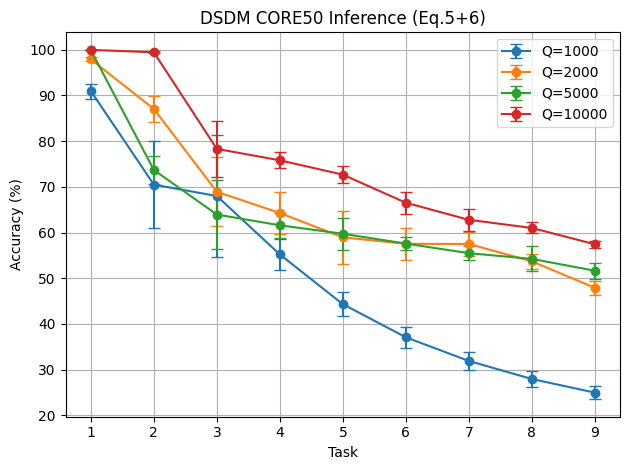

In [ ]:
for Q in Q_VALUES:
    print(f"\n=== Running DSDM with Q = {Q} ===")
    task_accs_all_seeds = []

    for seed in SEEDS:
        fix_seed(seed)
        n_tasks, classes_per_task = task_split
        task_splits = randomized_class_split(train_y, n_tasks=n_tasks, classes_per_task=classes_per_task, seed=seed)
        split_x, split_y = split_dataset_by_class(train_x, train_y, task_splits)
        split_tx, split_ty = split_dataset_by_class(test_x, test_y, task_splits)

        model = FASTER_DSDM(
            Q=Q,
            beta=0.5,
            Lambda=0.0022,
            Lambda_RT=0.0025,
            n_feat=512,
            n_class=n_class,
            prune_method=0,
            n_neighbors=20,
            contamination=0.0
        )

        test_data_seen = []
        acc_per_task = []

        for task_id, (x_batch, y_batch, tx, ty) in enumerate(zip(split_x, split_y, split_tx, split_ty), 1):
            model = model.train(x_batch[None, ...], y_batch[None, ...])
            if model.K > model.Q:
                model = model.prune(model.Address, model.Content, model.K, model.RT)

            test_data_seen.append((tx, ty))
            correct, total = 0, 0
            for t_x, t_y in test_data_seen:
                c, n = batched_inference(t_x, t_y, model)
                correct += c
                total += n
            acc = (correct / total) * 100
            acc_per_task.append(acc)
            print(f"Task {task_id} | RT = {float(model.RT):.4f} | Accuracy: {acc:.2f}%")

        task_accs_all_seeds.append(acc_per_task)

    task_accs_all_seeds = np.array(task_accs_all_seeds)
    mean_acc = task_accs_all_seeds.mean(axis=0)
    std_acc = task_accs_all_seeds.std(axis=0)
    avg_acc = mean_acc.mean()
    last_acc = mean_acc[-1]

    all_results.append({"Q": Q, "avg": avg_acc, "last": last_acc})
    plt.errorbar(range(1, len(mean_acc)+1), mean_acc, yerr=std_acc, fmt='-o', capsize=4, label=f"Q={Q}")

plt.xlabel("Task")
plt.ylabel("Accuracy (%)")
plt.title(f"DSDM {dataset.upper()} Inference (Eq.5+6)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("\n📊 Summary: Avg and Last Accuracy per Memory Budget (Q)")
for result in all_results:
    print(f"Q = {result['Q']}: Avg = {result['avg']:.2f}% | Last = {result['last']:.2f}%")


📊 Summary: Avg and Last Accuracy per Memory Budget (Q)
Q = 1000: Avg = 50.09% | Last = 24.95%
Q = 2000: Avg = 65.96% | Last = 47.89%
Q = 5000: Avg = 64.20% | Last = 51.63%
Q = 10000: Avg = 74.88% | Last = 57.43%


In [ ]:
qs = [r['Q'] for r in all_results]
avg_scores = [r['avg'] for r in all_results]
last_scores = [r['last'] for r in all_results]

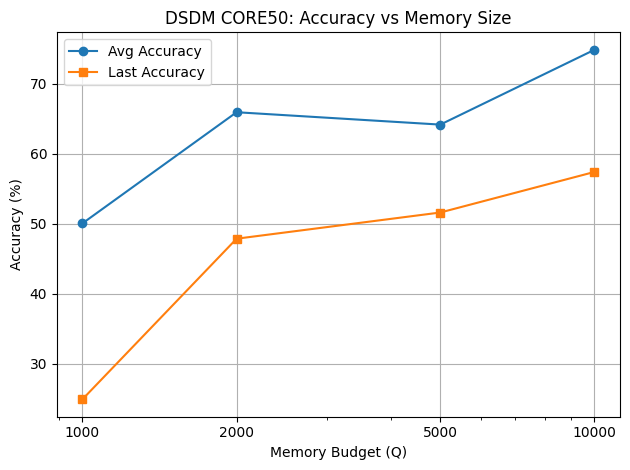

In [ ]:
plt.plot(qs, avg_scores, marker='o', label="Avg Accuracy")
plt.plot(qs, last_scores, marker='s', label="Last Accuracy")
plt.xscale("log")
plt.xticks(qs, labels=[str(q) for q in qs])
plt.xlabel("Memory Budget (Q)")
plt.ylabel("Accuracy (%)")
plt.title(f"DSDM {dataset.upper()}: Accuracy vs Memory Size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()